In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [50]:
# 데이터 불러오기
free_apps = pd.read_csv('Free_apps.csv')
grossing_apps = pd.read_csv('Grossing_apps.csv')
paid_apps = pd.read_csv('Paid_apps.csv')

In [65]:
# 데이터 병합
apps_data = pd.concat([free_apps, grossing_apps, paid_apps])

# 중복된 행 제거
apps_data = apps_data.drop_duplicates(subset=['App ID'])

In [66]:
# 필요한 열만 선택
apps_data = apps_data[['Category', 'Description']]

In [67]:
# 결측치 제거
apps_data.dropna(subset=['Category', 'Description'], inplace=True)

In [68]:
apps_data.head()

,Category,Description
0,Health & Fitness,1. The mobile health insurance card app is a p...
1,Video Players & Editors,TikTok Lite is a global video community that i...
2,Shopping,Shop on Temu for exclusive offers. \n\nNo matt...
3,Social,Say more with Threads — Instagram’s text-based...
4,Lifestyle,Through carbon neutrality activities that can ...


In [69]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [70]:
# 클러스터링 수행 (예: 7개의 클러스터)
kmeans = KMeans(n_clusters=7, random_state=42)
clusters = kmeans.fit_predict(X_tfidf)


c:\Users\jeleez\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [71]:
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF 벡터화
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_tfidf = vectorizer.fit_transform(apps_data['Description'])

In [73]:
from sklearn.cluster import KMeans

# 클러스터 개수 설정 (예: 7개의 상위 카테고리)
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(X_tfidf)

# 클러스터 결과를 데이터프레임에 추가
apps_data['Cluster'] = clusters

c:\Users\jeleez\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [74]:
# 클러스터별로 카테고리 확인
for cluster_num in range(n_clusters):
    print(f"Cluster {cluster_num}:")
    cluster_data = apps_data[apps_data['Cluster'] == cluster_num]
    print(cluster_data['Category'].value_counts())
    print("\n")

Cluster 0:
Category
Video Players & Editors    1
Shopping                   1
Social                     1
Photography                1
Name: count, dtype: int64


Cluster 1:
Category
Entertainment       2
Health & Fitness    1
Lifestyle           1
News & Magazines    1
Finance             1
Food & Drink        1
Tools               1
Name: count, dtype: int64


Cluster 2:
Category
Personalization    4
Productivity       1
Name: count, dtype: int64




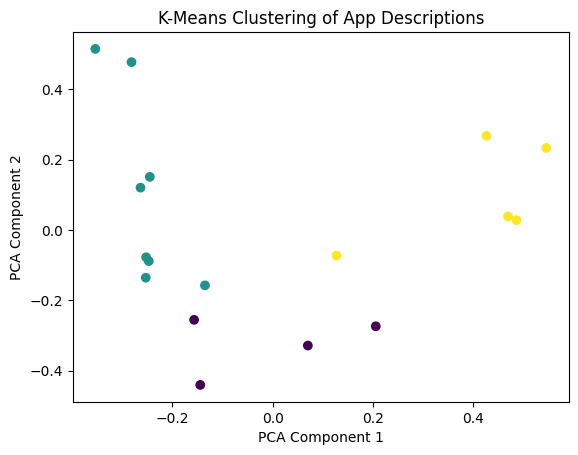

In [75]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# PCA로 차원 축소 후 시각화
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(X_tfidf.toarray())

plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=clusters, cmap='viridis')
plt.title('K-Means Clustering of App Descriptions')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

In [76]:
# 클러스터 번호를 상위 카테고리로 사용
apps_data['Super_Category'] = apps_data['Cluster']

# 상위 카테고리별로 그룹화된 데이터 확인
grouped_by_super_category = apps_data.groupby('Super_Category')

for super_category, group in grouped_by_super_category:
    print(f"Super Category (Cluster): {super_category}")
    print(group['Category'].value_counts())
    print("\n")

Super Category (Cluster): 0
Category
Video Players & Editors    1
Shopping                   1
Social                     1
Photography                1
Name: count, dtype: int64


Super Category (Cluster): 1
Category
Entertainment       2
Health & Fitness    1
Lifestyle           1
News & Magazines    1
Finance             1
Food & Drink        1
Tools               1
Name: count, dtype: int64


Super Category (Cluster): 2
Category
Personalization    4
Productivity       1
Name: count, dtype: int64




In [77]:
apps_data.head()

,Category,Description,Cluster,Super_Category
0,Health & Fitness,1. The mobile health insurance card app is a p...,1,1
1,Video Players & Editors,TikTok Lite is a global video community that i...,0,0
2,Shopping,Shop on Temu for exclusive offers. \n\nNo matt...,0,0
3,Social,Say more with Threads — Instagram’s text-based...,0,0
4,Lifestyle,Through carbon neutrality activities that can ...,1,1


In [78]:
import numpy as np

In [79]:
# 클러스터별 주요 키워드 추출 함수
def get_top_keywords(tfidf_matrix, clusters, top_n=5):
    # 클러스터 중심의 TF-IDF 가중치 합계 계산
    cluster_centers = np.zeros((np.unique(clusters).size, tfidf_matrix.shape[1]))
    
    for cluster in np.unique(clusters):
        cluster_centers[cluster] = tfidf_matrix[clusters == cluster].mean(axis=0)
    
    # 각 클러스터의 주요 키워드 추출
    terms = vectorizer.get_feature_names_out()
    top_keywords = []
    
    for cluster in range(cluster_centers.shape[0]):
        center = cluster_centers[cluster]
        top_indices = center.argsort()[::-1][:top_n]  # 상위 n개의 인덱스
        keywords = [terms[i] for i in top_indices]  # 상위 n개의 키워드
        top_keywords.append(keywords)
    
    return top_keywords

In [80]:
# 클러스터별 상위 5개 키워드 추출
top_keywords_per_cluster = get_top_keywords(X_tfidf, clusters, top_n=5)


In [81]:
# 클러스터별 주요 키워드 출력
for cluster_num, keywords in enumerate(top_keywords_per_cluster):
    print(f"Cluster {cluster_num} Top Keywords: {', '.join(keywords)}")

Cluster 0 Top Keywords: temu, instagram, tiktok, min, hwa
Cluster 1 Top Keywords: news, coupang, tv, game, receive
Cluster 2 Top Keywords: watch, https, face, com, ads


In [82]:
# 키워드 기반으로 상위 카테고리 이름 생성
def generate_category_name(keywords):
    return " & ".join(keywords[:2])  # 상위 2개의 키워드를 연결하여 이름 생성

In [83]:
# 클러스터별 상위 카테고리 이름 생성 및 출력
for cluster_num, keywords in enumerate(top_keywords_per_cluster):
    category_name = generate_category_name(keywords)
    print(f"Cluster {cluster_num} Name: {category_name}")

Cluster 0 Name: temu & instagram
Cluster 1 Name: news & coupang
Cluster 2 Name: watch & https


### Word2Vec

In [84]:
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
import numpy as np

In [85]:
# Description 텍스트를 토큰화
tokenized_descriptions = [desc.split() for desc in apps_data['Description']]

In [86]:
# Word2Vec 모델 학습
word2vec_model = Word2Vec(sentences=tokenized_descriptions, vector_size=100, window=5, min_count=2, workers=4)

In [87]:
# 클러스터 내에서 가장 빈도가 높은 단어 추출
def get_top_words_word2vec(model, cluster_data, top_n=5):
    word_counts = {}
    for desc in cluster_data['Description']:
        words = desc.split()
        for word in words:
            if word in model.wv:
                word_counts[word] = word_counts.get(word, 0) + 1
    top_words = sorted(word_counts.items(), key=lambda item: item[1], reverse=True)[:top_n]
    return [word for word, _ in top_words]

In [88]:
# 클러스터별 주요 단어 추출
for cluster_num in range(n_clusters):
    cluster_data = apps_data[apps_data['Cluster'] == cluster_num]
    top_words = get_top_words_word2vec(word2vec_model, cluster_data)
    print(f"Cluster {cluster_num} Top Words: {', '.join(top_words)}")

Cluster 0 Top Words: and, the, to, your, •
Cluster 1 Top Words: and, the, you, -, to
Cluster 2 Top Words: -, the, to, you, and


In [89]:
# 키워드 기반으로 상위 카테고리 이름 생성
def generate_category_name_from_word2vec(top_words):
    return " & ".join(top_words[:2])  # 상위 2개의 단어로 이름 생성

In [90]:
# 클러스터별 상위 카테고리 이름 생성 및 출력
for cluster_num in range(n_clusters):
    cluster_data = apps_data[apps_data['Cluster'] == cluster_num]
    top_words = get_top_words_word2vec(word2vec_model, cluster_data)
    category_name = generate_category_name_from_word2vec(top_words)
    print(f"Cluster {cluster_num} Name: {category_name}")

Cluster 0 Name: and & the
Cluster 1 Name: and & the
Cluster 2 Name: - & the


### LDA

In [91]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

In [92]:
# Count Vectorizer 사용하여 문서-단어 행렬 생성
count_vectorizer = CountVectorizer(stop_words='english', max_features=5000)
X_counts = count_vectorizer.fit_transform(apps_data['Description'])

In [93]:
# LDA 모델 학습
lda_model = LatentDirichletAllocation(n_components=n_clusters, random_state=42)
lda_topics = lda_model.fit_transform(X_counts)

In [94]:
# 각 클러스터의 상위 단어 추출
def get_top_words_lda(model, feature_names, top_n=10):
    top_words = []
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-top_n - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        top_words.append(top_features)
    return top_words


In [95]:
# 각 주제별 상위 단어 추출
feature_names = count_vectorizer.get_feature_names_out()
top_words_per_topic = get_top_words_lda(lda_model, feature_names, top_n=5)



In [96]:
# 주제별 주요 단어 출력
for topic_num, top_words in enumerate(top_words_per_topic):
    print(f"Topic {topic_num} Top Words: {', '.join(top_words)}")

Topic 0 Top Words: app, receive, samsung, ads, tv
Topic 1 Top Words: news, coupang, delivery, eats, app
Topic 2 Top Words: https, com, watch, face, instagram


In [97]:
# 주제 기반으로 상위 카테고리 이름 생성
def generate_category_name_from_lda(top_words):
    return " & ".join(top_words[:2])  # 상위 2개의 단어로 이름 생성


In [98]:
# 클러스터별 상위 카테고리 이름 생성 및 출력
for topic_num, top_words in enumerate(top_words_per_topic):
    category_name = generate_category_name_from_lda(top_words)
    print(f"Topic {topic_num} Name: {category_name}")

Topic 0 Name: app & receive
Topic 1 Name: news & coupang
Topic 2 Name: https & com
